In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

(3, 64, 96)


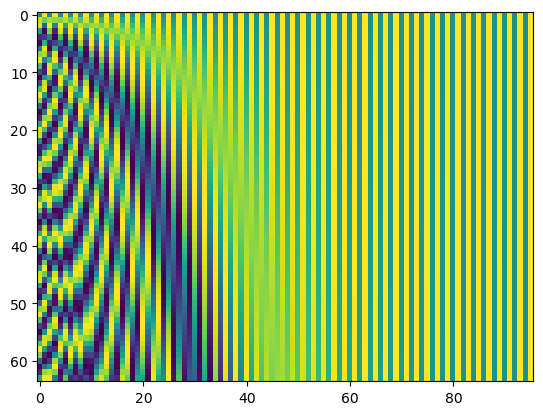

In [2]:
class SinusoidalPositionalEmbedding1d(nn.Module):
    def __init__(self, embedding_dim, device):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.device = device

    def forward(self, x):
        bs, seq_len = x.shape
        pe = torch.zeros(seq_len, self.embedding_dim).to(device=self.device)
        pos = torch.arange(start=0, end=seq_len, device=self.device).unsqueeze(1)
        denom = 1 / (10000.0 ** (torch.arange(start=0, end=self.embedding_dim, step=2, device=self.device) / self.embedding_dim))
        pe[:, 0::2] = torch.sin(pos * denom)
        pe[:, 1::2] = torch.cos(pos * denom)
        pe = pe.unsqueeze(0).repeat(bs, 1, 1)
        return pe
    
spe = SinusoidalPositionalEmbedding1d(96, torch.device('cpu'))

x = torch.rand(3, 64)
rst = spe(x).numpy()
print(rst.shape)
plt.imshow(rst[0], aspect='auto', cmap='viridis')
plt.show()

tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17],
        [18],
        [19],
        [20],
        [21],
        [22],
        [23],
        [24],
        [25],
        [26],
        [27],
        [28],
        [29],
        [30],
        [31],
        [32],
        [33],
        [34],
        [35],
        [36],
        [37],
        [38],
        [39],
        [40],
        [41],
        [42],
        [43],
        [44],
        [45],
        [46],
        [47],
        [48],
        [49],
        [50],
        [51],
        [52],
        [53],
        [54],
        [55],
        [56],
        [57],
        [58],
        [59],
        [60],
        [61],
        [62],
        [63],
        [64],
        [65],
        [66],
        [67],
        [68],
        [69],
        [70],
      

TypeError: Invalid shape (4, 96, 16) for image data

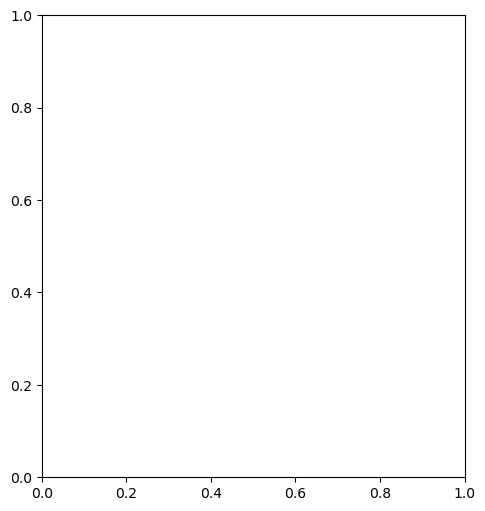

In [50]:
class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, x):
        bs, nh, seq_len, embedding_dim = x.shape
        pos = torch.arange(start=0, end=seq_len, step=1, device=self.device).unsqueeze(1)
        theta = 1 / (10000.0 ** (torch.arange(start=0, end=embedding_dim, step=2, device=self.device) / embedding_dim))
        pos_angle = (pos * theta).repeat_interleave(2, dim=-1)
        print(pos, theta)
        cos_r = torch.cos(pos_angle)
        sin_r = torch.sin(pos_angle)
        x2 = torch.stack([-x[:, :, :, 1::2], x[:, :, :, 0::2]], dim=-1).reshape(x.shape)
        rot_x = x * sin_r + x2 * cos_r
        return rot_x
    
rpe = RotaryPositionalEmbedding(torch.device('cpu'))
    
x0 = torch.rand(3, 4, 96, 16)
x1 = torch.ones(3, 4, 96, 16)
rst0 = rpe(x0).numpy()
rst1 = rpe(x1).numpy()

print(rst0.shape, rst1.shape)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(rst0[0], aspect='auto', cmap='viridis')
plt.subplot(1, 2, 2)
plt.imshow(rst1[0], aspect='auto', cmap='viridis')
plt.show()

In [66]:
class RotaryPositionalEmbeddings1(nn.Module):

    def __init__(self, d: int, base: int = 10_000):
        """
        * `d` is the number of features $d$
        * `base` is the constant used for calculating $\Theta$
        """
        super().__init__()

        self.base = base
        self.d = d
        self.cos_cached = None
        self.sin_cached = None

    def _build_cache(self, x: torch.Tensor):
        """
        Cache $\cos$ and $\sin$ values
        """
        # Return if cache is already built
        if self.cos_cached is not None and x.shape[0] <= self.cos_cached.shape[0]:
            return

        # Get sequence length
        seq_len = x.shape[0]

        # $\Theta = {\theta_i = 10000^{-\frac{2(i-1)}{d}}, i \in [1, 2, ..., \frac{d}{2}]}$
        theta = 1. / (self.base ** (torch.arange(0, self.d, 2).float() / self.d)).to(x.device)

        # Create position indexes `[0, 1, ..., seq_len - 1]`
        seq_idx = torch.arange(seq_len, device=x.device).float().to(x.device)

        # Calculate the product of position index and $\theta_i$
        idx_theta = torch.einsum('n,d->nd', seq_idx, theta)

        # Concatenate so that for row $m$ we have
        # $[m \theta_0, m \theta_1, ..., m \theta_{\frac{d}{2}}, m \theta_0, m \theta_1, ..., m \theta_{\frac{d}{2}}]$
        idx_theta2 = torch.cat([idx_theta, idx_theta], dim=1)

        # Cache them
        self.cos_cached = idx_theta2.cos()[:, None, None, :]
        self.sin_cached = idx_theta2.sin()[:, None, None, :]

    def _neg_half(self, x: torch.Tensor):
        # $\frac{d}{2}$
        d_2 = self.d // 2

        # Calculate $[-x^{(\frac{d}{2} + 1)}, -x^{(\frac{d}{2} + 2)}, ..., -x^{(d)}, x^{(1)}, x^{(2)}, ..., x^{(\frac{d}{2})}]$
        return torch.cat([-x[:, :, :, d_2:], x[:, :, :, :d_2]], dim=-1)

    def forward(self, x: torch.Tensor):
        """
        * `x` is the Tensor at the head of a key or a query with shape `[seq_len, batch_size, n_heads, d]`
        """
        # Cache $\cos$ and $\sin$ values
        self._build_cache(x)

        # Split the features, we can choose to apply rotary embeddings only to a partial set of features.
        x_rope, x_pass = x[..., :self.d], x[..., self.d:]

        # Calculate
        # $[-x^{(\frac{d}{2} + 1)}, -x^{(\frac{d}{2} + 2)}, ..., -x^{(d)}, x^{(1)}, x^{(2)}, ..., x^{(\frac{d}{2})}]$
        neg_half_x = self._neg_half(x_rope)

        # Calculate
        #
        # \begin{align}
        # \begin{pmatrix}
        # x^{(i)}_m \cos m \theta_i - x^{(i + \frac{d}{2})}_m \sin m \theta_i \\
        # x^{(i + \frac{d}{2})}_m \cos m\theta_i + x^{(i)}_m \sin m \theta_i \\
        # \end{pmatrix} \\
        # \end{align}
        #
        # for $i \in {1, 2, ..., \frac{d}{2}}$
        print(neg_half_x, x_rope)
        x_rope = (x_rope * self.cos_cached[:x.shape[0]]) + (neg_half_x * self.sin_cached[:x.shape[0]])

        #
        return torch.cat((x_rope, x_pass), dim=-1)

In [67]:
def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids):
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

class RotaryEmbedding(torch.nn.Module):
    def __init__(self, dim, max_position_embeddings=1024, base=10000, device=None):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

        self._set_cos_sin_cache(
            seq_len=max_position_embeddings, device=self.inv_freq.device, dtype=torch.get_default_dtype()
        )

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        t = torch.arange(self.max_seq_len_cached, device=device, dtype=self.inv_freq.dtype)

        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos()[None, None, :, :].to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin()[None, None, :, :].to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        return (
            self.cos_cached[:, :, :seq_len, ...].to(dtype=x.dtype),
            self.sin_cached[:, :, :seq_len, ...].to(dtype=x.dtype),
        )


In [68]:
from einops import rearrange
def rotate_half(x):
    x = rearrange(x, '... (d r) -> ... d r', r = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    return rearrange(x, '... d r -> ... (d r)')

In [69]:

x = torch.tensor([[1, 2, 3, 4, 11, 12], [4, 5, 6, 7, 13, 14], [7, 8, 9, 10, 15, 16]], dtype=torch.float)
x = x[:, None, None, :]
print(x.shape)

rotary_pe = RotaryPositionalEmbeddings1(6)
rpe = RotaryPositionalEmbedding(torch.device('cpu'))
print(rotary_pe(x))
print(rpe(x))

torch.Size([3, 1, 1, 6])
tensor([[[[ -4., -11., -12.,   1.,   2.,   3.]]],


        [[[ -7., -13., -14.,   4.,   5.,   6.]]],


        [[[-10., -15., -16.,   7.,   8.,   9.]]]]) tensor([[[[ 1.,  2.,  3.,  4., 11., 12.]]],


        [[[ 4.,  5.,  6.,  7., 13., 14.]]],


        [[[ 7.,  8.,  9., 10., 15., 16.]]]])
tensor([[[[  1.0000,   2.0000,   3.0000,   4.0000,  11.0000,  12.0000]]],


        [[[ -3.7291,   4.3914,   5.9698,   7.1480,  13.2180,  14.0129]]],


        [[[-12.0060,   6.5751,   8.9310,   2.2036,  15.6770,  16.0386]]]])
tensor([[0]]) tensor([1.0000, 0.0464, 0.0022])
tensor([[[[ -2.,   1.,  -4.,   3., -12.,  11.]]],


        [[[ -5.,   4.,  -7.,   6., -14.,  13.]]],


        [[[ -8.,   7., -10.,   9., -16.,  15.]]]])


In [74]:
xshaped = x.reshape(3, -1, 1, 6 // 2, 2)
x_out2 = torch.stack(
        [
            -xshaped[..., 1],
            xshaped[..., 0],
        ],
        -1,
    )
x_out2.flatten(3)

tensor([[[[ -2.,   1.,  -4.,   3., -12.,  11.]]],


        [[[ -5.,   4.,  -7.,   6., -14.,  13.]]],


        [[[ -8.,   7., -10.,   9., -16.,  15.]]]])

In [ ]:
tensor([[[[ -2.0000,   1.0000,  -4.0000,   3.0000, -12.0000,  11.0000],
          [  0.6644,   6.3686,  -6.7141,   6.3183, -13.9720,  13.0301],
          [  9.6943,   4.3614,  -9.1227,   9.8882, -15.9352,  15.0688]]]])